This notebook examines the "FullText" column and "notes" column of the dataset and finds cosine similarity index after a TF-IDF vectorisation:

In [2]:
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F
import pandas as pd
import numpy as np
import re
import unidecode
import spacy
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

ModuleNotFoundError: No module named 'torch'

In [ ]:
# === Number-preserving normalization ===
def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    text = unidecode.unidecode(text)              # fix unicode
    text = text.lower()                            # lowercase
    # text = re.sub(r"[^a-z0-9\s.,;:'!?/-]", " ", text)  # keep numbers & punctuation
    text = re.sub(r"\b[a-z]\b", " ", text)        # remove isolated letters (OCR noise)
    text = re.sub(r"(\w+)-\s+(\w+)", r"\1\2", text)    # fix broken hyphens
    text = re.sub(r"\s+", " ", text).strip()      # collapse spaces
    text = re.sub(r"(.)\1{2,}", r"\1", text)      # collapse repeated chars
    return text

# === Load spaCy with only what's needed ===
# Disable named entity recognition (ner) and dependency parser to save time
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "textcat"])

def lemmatize_texts(texts, batch_size=1000, n_process=4):
    """
    Lemmatize a list of texts efficiently using spaCy's nlp.pipe().
    Args:
        texts (List[str]): list of documents
        batch_size (int): how many docs per batch
        n_process (int): how many processes to run in parallel
    Returns:
        List[str]: lemmatized text for each document
    """
    lemmatized = []
    for doc in tqdm(
        nlp.pipe(texts, batch_size=batch_size, n_process=n_process),
        total=len(texts),
        desc="Lemmatizing",
    ):
        lemmas = [
            token.lemma_
            for token in doc
            if not token.is_punct and not token.is_space
        ]
        lemmatized.append(" ".join(lemmas))
    return lemmatized



In [ ]:
df1 = pd.read_csv("/mnt/research/artha/india-violence-archive/dataset/vw_matched_on_sourcedate_766.csv", encoding="latin1")

In [ ]:
df1

,vw_row_no,numericpubdate,year,month,month_by_n,day,country,state,statecode,key,...,new_clean_source_date_14,new_clean_source_date_15,new_clean_source_date_16,new_clean_source_date_17,new_clean_source_date_18,new_clean_source_date_19,mi_og_sd,mi_clean_sd,no_sd,m_766_recordid
0,4,10feb1950,1950,february,2,9.0,india,west bengal,wb,wb195002,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,3,Matched (3)
1,4,11feb1950,1950,february,2,9.0,india,west bengal,wb,wb195002,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,3,Matched (3)
2,4,16feb1950,1950,february,2,9.0,india,west bengal,wb,wb195002,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,3,Matched (3)
3,6,06mar1950,1950,march,3,4.0,india,uttar pradesh,up,up195003,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,Matched (3)
4,9,09mar1950,1950,march,3,4.0,india,uttar pradesh,up,up195003,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,2,Matched (3)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,1187,12feb1995,1995,february,2,10.0,india,uttar pradesh,up,up199502,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,3,Matched (3)
762,1187,13feb1995,1995,february,2,10.0,india,uttar pradesh,up,up199502,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,3,Matched (3)
763,1188,14feb1995,1995,february,2,13.0,india,delhi,de,de199502,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,Matched (3)
764,1190,16apr1995,1995,april,4,15.0,india,tamil nadu,tn,tn199504,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,Matched (3)


Load the toi parsed all ds

In [ ]:
df2 = pd.read_csv("/mnt/research/artha/india-violence-archive/dataset/toi_parsed_all.csv")
# change the column name 'NumericPubDate' to 'numericpubdate'
df2.rename(columns={'NumericPubDate': 'numericpubdate'}, inplace=True)
df2['numericpubdate'] = df2['numericpubdate'].astype(str)
df2['numericpubdate'] = pd.to_datetime(df2['numericpubdate'].astype(str), format='%Y%m%d')
df2['numericpubdate'] = df2['numericpubdate'].dt.strftime('%d%b%Y').str.lower()
df2[['numericpubdate']].head()


/tmp/local/62794567/ipykernel_3827527/1729372689.py:1: DtypeWarning: Columns (11,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv("/mnt/research/artha/india-violence-archive/dataset/toi_parsed_all.csv")


,numericpubdate
0,24feb1998
1,22may1996
2,17sep1997
3,16sep1998
4,03aug1839


In [ ]:
df_merged = pd.merge(df1, df2, on='numericpubdate', how='left')

NameError: name 'df1' is not defined

In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136666 entries, 0 to 136665
Data columns (total 88 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   vw_row_no                     136666 non-null  int64  
 1   numericpubdate                136666 non-null  object 
 2   year                          136666 non-null  int64  
 3   month                         136666 non-null  object 
 4   month_by_n                    136666 non-null  int64  
 5   day                           133455 non-null  float64
 6   country                       136666 non-null  object 
 7   state                         135319 non-null  object 
 8   statecode                     135143 non-null  object 
 9   key                           136666 non-null  object 
 10  district                      91278 non-null   object 
 11  town_city                     122064 non-null  object 
 12  village                       12629 non-null

In [ ]:
df_merged['FullText'].replace('', pd.NA).isna().sum()

np.int64(1913)

In [ ]:
df_merged

,vw_row_no,numericpubdate,year,month,month_by_n,day,country,state,statecode,key,...,Contributor.FirstName,Contributor.NameSuffix,Contributor.MiddleName,FullText,ObjectType,Contributor.OrganizationName,Publication.Title,Publisher,Contributor.OriginalForm,LanguageCode
0,4,10feb1950,1950,february,2,9.0,india,west bengal,wb,wb195002,...,NaN,NaN,NaN,CADET HONOURED The passing-out...,Image/Photograph,NaN,The Times of India (1861-current),"Bennett, Coleman & Company Limited",NaN,ENG
1,4,10feb1950,1950,february,2,9.0,india,west bengal,wb,wb195002,...,NaN,NaN,NaN,RESERVE BANK OF INDIA DIRECTORATE OF PUBLICITY...,"['Classified Advertisement', 'Advertisement']",NaN,The Times of India (1861-current),"Bennett, Coleman & Company Limited",NaN,ENG
2,4,10feb1950,1950,february,2,9.0,india,west bengal,wb,wb195002,...,NaN,NaN,NaN,DEVELOPMENT OF FISHERIES Mr Ta...,"['Feature', 'Article']",NaN,The Times of India (1861-current),"Bennett, Coleman & Company Limited",NaN,ENG
3,4,10feb1950,1950,february,2,9.0,india,west bengal,wb,wb195002,...,NaN,NaN,NaN,FOOD PRODUCTION IN MADRAS Big ...,Front Page/Cover Story,NaN,The Times of India (1861-current),"Bennett, Coleman & Company Limited",NaN,ENG
4,4,10feb1950,1950,february,2,9.0,india,west bengal,wb,wb195002,...,NaN,NaN,NaN,ELLISON ELECTRIC 11GEAR For Me...,"['Feature', 'Article']",NaN,The Times of India (1861-current),"Bennett, Coleman & Company Limited",NaN,ENG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136661,1191,07may1995,1995,may,5,6.0,india,uttar pradesh,up,up199505,...,NaN,NaN,NaN,SSSSSISISiSSSZZIS ALLIANCE INVITED FOR BEAUTIF...,"['Classified Advertisement', 'Advertisement']",NaN,The Times of India (1861-current),"Bennett, Coleman & Company Limited",NaN,ENG
136662,1191,07may1995,1995,may,5,6.0,india,uttar pradesh,up,up199505,...,NaN,NaN,NaN,People are failures not the system says Sitara...,Front Page/Cover Story,NaN,The Times of India (1861-current),"Bennett, Coleman & Company Limited",NaN,ENG
136663,1191,07may1995,1995,may,5,6.0,india,uttar pradesh,up,up199505,...,Raghu,NaN,NaN,Reintroduction of bridge loan facility likely ...,"['Feature', 'Article']",NaN,The Times of India (1861-current),"Bennett, Coleman & Company Limited",Raghu Mohan,ENG
136664,1191,07may1995,1995,may,5,6.0,india,uttar pradesh,up,up199505,...,NaN,NaN,NaN,Dark dry days ahead as the heat rolls on ...,"['Feature', 'Article']",NaN,The Times of India (1861-current),"Bennett, Coleman & Company Limited",NaN,ENG


In [ ]:
df = df_merged
del df_merged


In [ ]:
# remove the .0 from the integers in killed, injured and arrests columns
df['killed'] = df['killed'].astype(str).str.replace('.0', '', regex=False)
df['injured'] = df['injured'].astype(str).str.replace('.0', '', regex=False)
df['arrests'] = df['arrests'].astype(str).str.replace('.0', '', regex=False)

In [ ]:
## add the strings from the columns month, state, town_city, village, killed, injured, arrests, officials into the notes column

df['notes'] = df.apply(lambda x: f"{x['month']} {x['state']} {x['town_city']} {x['village']} killed {x['killed']} injure {x['injured']} arrest {x['arrests']} {x['officials']} {x['notes']}", axis=1) 

In [ ]:
df["FullText_clean"] = df["FullText"].apply(clean_text)
df["notes_clean"] = df["notes"].apply(clean_text)

In [ ]:
import spacy
from tqdm import tqdm
import pandas as pd

# === Apply to both columns ===
print("Lemmatizing FullText_clean...")
df["FullText_lemma"] = lemmatize_texts(df["FullText_clean"].astype(str).tolist())

print("Lemmatizing notes_clean...")
df["notes_lemma"] = lemmatize_texts(df["notes_clean"].astype(str).tolist())

print("✅ Lemmatization done!")

Lemmatizing FullText_clean...


Lemmatizing: 100%|██████████| 132259/132259 [12:41<00:00, 173.59it/s]


Lemmatizing notes_clean...


Lemmatizing: 100%|██████████| 132259/132259 [05:48<00:00, 379.31it/s] 

✅ Lemmatization done!


In [ ]:
#compare the FullText with full_text_lem and notes with notes_lem
df[['FullText', 'FullText_clean', 'FullText_lemma', 'notes', 'notes_clean', 'notes_lemma']]

,FullText,FullText_clean,FullText_lemma,notes,notes_clean,notes_lemma
0,CADET HONOURED The passing-out...,cadet honoured the passing-out parade of the t...,cadet honour the pass out parade of the traini...,february west bengal calcutta nan killed 3 inj...,february west bengal calcutta nan killed 3 inj...,february west bengal calcutta nan kill 3 injur...
1,RESERVE BANK OF INDIA DIRECTORATE OF PUBLICITY...,reserve bank of india directorate of publicity...,reserve bank of india directorate of publicity...,february west bengal calcutta nan killed 3 inj...,february west bengal calcutta nan killed 3 inj...,february west bengal calcutta nan kill 3 injur...
2,DEVELOPMENT OF FISHERIES Mr Ta...,development of fisheries mr tapases address an...,development of fishery mr tapase address an im...,february west bengal calcutta nan killed 3 inj...,february west bengal calcutta nan killed 3 inj...,february west bengal calcutta nan kill 3 injur...
3,FOOD PRODUCTION IN MADRAS Big ...,food production in madras big shortage feared ...,food production in madra big shortage fear mad...,february west bengal calcutta nan killed 3 inj...,february west bengal calcutta nan killed 3 inj...,february west bengal calcutta nan kill 3 injur...
4,ELLISON ELECTRIC 11GEAR For Me...,ellison electric 11gear for medium and high vo...,ellison electric 11gear for medium and high vo...,february west bengal calcutta nan killed 3 inj...,february west bengal calcutta nan killed 3 inj...,february west bengal calcutta nan kill 3 injur...
...,...,...,...,...,...,...
132254,SSSSSISISiSSSZZIS ALLIANCE INVITED FOR BEAUTIF...,sisisiszzis alliance invited for beautiful sin...,sisisiszzis alliance invite for beautiful sind...,may uttar pradesh aligarh nan killed 1 injure ...,may uttar pradesh aligarh nan killed 1 injure ...,may uttar pradesh aligarh nan kill 1 injure 3 ...
132255,People are failures not the system says Sitara...,people are failures not the system says sitara...,people be failure not the system say sitaram k...,may uttar pradesh aligarh nan killed 1 injure ...,may uttar pradesh aligarh nan killed 1 injure ...,may uttar pradesh aligarh nan kill 1 injure 3 ...
132256,Reintroduction of bridge loan facility likely ...,reintroduction of bridge loan facility likely ...,reintroduction of bridge loan facility likely ...,may uttar pradesh aligarh nan killed 1 injure ...,may uttar pradesh aligarh nan killed 1 injure ...,may uttar pradesh aligarh nan kill 1 injure 3 ...
132257,Dark dry days ahead as the heat rolls on ...,dark dry days ahead as the heat rolls on with ...,dark dry day ahead as the heat roll on with th...,may uttar pradesh aligarh nan killed 1 injure ...,may uttar pradesh aligarh nan killed 1 injure ...,may uttar pradesh aligarh nan kill 1 injure 3 ...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
# Replace NaN or None with empty strings
df['FullText_lemma'] = df['FullText_lemma'].fillna('')
df['notes_lemma'] = df['notes_lemma'].fillna('')

# Initialize TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')

# Fit on combined corpus (so both columns share the same vocabulary)
vectorizer.fit(df['FullText_lemma'].tolist() + df['notes_lemma'].tolist())

# Transform each column
tfidf_full = vectorizer.transform(df['FullText_lemma'])
tfidf_notes = vectorizer.transform(df['notes_lemma'])

# Compute cosine similarity row by row
df['tfidf_similarity'] = [
    cosine_similarity(tfidf_full[i], tfidf_notes[i])[0][0] for i in range(len(df))
]

# See results
print(df[['FullText', 'notes', 'tfidf_similarity']])


                                                 FullText  \
0       CADET HONOURED                 The passing-out...   
1       RESERVE BANK OF INDIA DIRECTORATE OF PUBLICITY...   
2       DEVELOPMENT OF FISHERIES                 Mr Ta...   
3       FOOD PRODUCTION IN MADRAS                 Big ...   
4       ELLISON ELECTRIC 11GEAR                 For Me...   
...                                                   ...   
132254  SSSSSISISiSSSZZIS ALLIANCE INVITED FOR BEAUTIF...   
132255  People are failures not the system says Sitara...   
132256  Reintroduction of bridge loan facility likely ...   
132257  Dark dry days ahead as the heat rolls on      ...   
132258  CID seizes benami shares worth 650 or         ...   

                                                    notes  tfidf_similarity  
0       february west bengal calcutta nan killed 3 inj...          0.000000  
1       february west bengal calcutta nan killed 3 inj...          0.027641  
2       february west bengal calc

In [ ]:
df = df.sort_values('tfidf_similarity', ascending=False)
df = df.groupby('numericpubdate', as_index=False).first()

In [ ]:
df[['RecordID','FullText', 'notes', 'tfidf_similarity']].iloc[0]

RecordID                                                  347338357.0
FullText            Question on Aligarh riots sparks Lok Sabha upr...
notes               march uttar pradesh aligarh nan killed 16 inju...
tfidf_similarity                                             0.239055
Name: 0, dtype: object

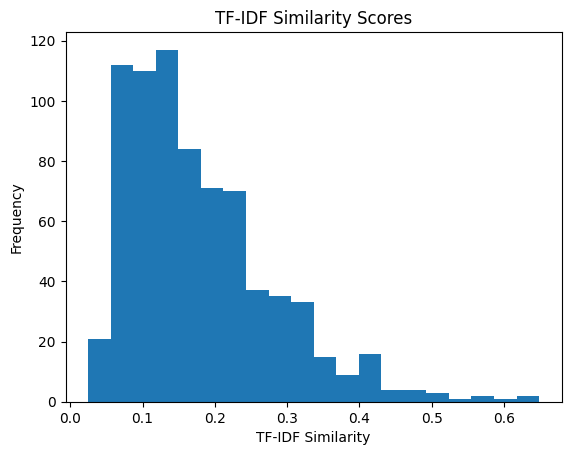

In [ ]:
## create a histogram of the tfidf_similarity scores
import matplotlib.pyplot as plt
plt.hist(df['tfidf_similarity'], bins=20)
plt.xlabel('TF-IDF Similarity')
plt.ylabel('Frequency')
plt.title('TF-IDF Similarity Scores')
plt.show()


In [ ]:
df.to_csv("/mnt/research/artha/india-violence-archive/dataset/unmatched_fulltext_ogvwrow_tfidf_similarity.csv")